In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
__file__ = os.path.abspath('')
dir_path = '/'.join(os.path.realpath(__file__).split('/')[:-1])
sys.path.append(f'{dir_path}/sabatinilab-glm/backend')
sys.path.append(f'{dir_path}/..')
sys.path.append(f'{dir_path}/backend')
sys.path.append(f'{dir_path}/../backend')
# sys.path.append('./backend')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GroupShuffleSplit

import sglm
import sglm_cv
import sglm_pp
import sglm_ez

# Loading in the DesignMatrix (and response) Data

In [3]:
df = pd.read_csv('../C39_2020_11_03_designMat.csv').drop('Unnamed: 0', axis=1)

if 'index' in df.columns:
    df = df.drop('index', axis=1)

display(df)

,nTrial,iBlock,ENLPenalty,TO,responseTime,Cue,decision,switch,selReward,post,lickReward,lickNoReward,lickLeft,lickRight,lickSwitch,grnR,grnL
0,4.0,1.0,0,0,0,0,0.0,0.0,0,0.0,0,0,0,0,0,157.86484,890.27795
1,4.0,1.0,0,0,0,0,0.0,0.0,0,0.0,0,0,0,0,0,157.91985,911.16095
2,4.0,1.0,0,0,0,0,0.0,0.0,0,0.0,0,0,0,0,0,157.99931,907.63180
3,4.0,1.0,0,0,0,0,0.0,0.0,0,0.0,0,0,0,0,0,158.07393,911.70294
4,4.0,1.0,0,0,0,0,0.0,0.0,0,0.0,0,0,0,0,0,158.14862,910.94010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235727,236.0,12.0,0,0,0,0,0.0,0.0,0,0.0,0,0,0,0,0,153.91246,834.16540
235728,236.0,12.0,0,0,0,0,0.0,0.0,0,0.0,0,0,0,0,0,153.89035,835.16254
235729,236.0,12.0,0,0,0,0,0.0,0.0,0,0.0,0,0,0,0,0,153.86548,832.78430
235730,236.0,12.0,0,0,0,0,0.0,0.0,0,0.0,0,0,0,0,0,153.86433,835.03350


# Converting photometry response to a differential rather than raw output

,grnL,grnL_diff
0,890.27795,NaN
1,911.16095,20.88300
2,907.63180,-3.52915
3,911.70294,4.07114
4,910.94010,-0.76284


Text(0.5, 0, 'Timestep Index')

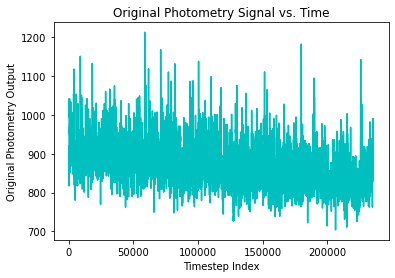

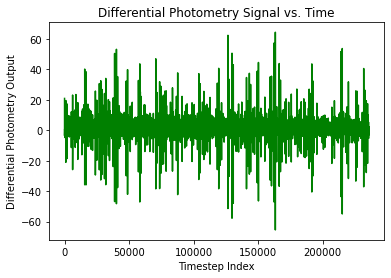

In [4]:
y_setup_col = 'grnL' # photometry response
df = sglm_ez.diff_cols(df, ['grnL'])

# Demonstrative first 5 timesteps of photometry signal vs. differential
display(df[['grnL', 'grnL_diff']].head())

# Plotting original photometry output (excluding first timestep)
plt.figure()
df['grnL'].iloc[1:].plot(color='c')
plt.title('Original Photometry Signal vs. Time')
plt.ylabel('Original Photometry Output')
plt.xlabel('Timestep Index')

# Plotting photometry differential output (excluding first timestep)
plt.figure()
df['grnL_diff'].iloc[1:].plot(color='g')
plt.title('Differential Photometry Signal vs. Time')
plt.ylabel('Differential Photometry Output')
plt.xlabel('Timestep Index')

# Specifying columns to retain for GLM fitting

In [5]:
X_cols = [
    # 'nTrial', # trial ID
    # 'iBlock', # block number within session
    # 'CuePenalty', # lick during cue period (no directionality yet, so binary 0,1) # Keep
    # 'ENLPenalty', # lick during ENL period (no directionality yet, 0,1) # Keep
    # # 'Select', # binary selection lick
    # # 'Consumption', # consumption period (from task perspective)
    # # 'TO', # timeout trial
    # # 'responseTime', # task state cue to selection window
    # # 'ENL', # task state ENL window
    # 'Cue', # task state Cue window # Keep (and all after)
    # 'decision', # choice lick direction (aligned to select but with directionality -1,1)
    # 'switch', # switch from previous choice on selection (-1,1)
    # 'selR', # select reward (-1,1) aligned to selection
    # 'selHigh', # select higher probability port (-1,1)
    # 'Reward', # reward vs no reward during consumption period (-1,1)
    # 'post', # log-odds probability

    'nTrial',
    'iBlock',
    'ENLPenalty',
    # 'TO',
    'responseTime',
    'Cue',
    'decision',
    'switch',
    'selReward',
    'post',
    'lickReward',
    'lickNoReward',
    'lickLeft',
    'lickRight',
    'lickSwitch',
    'grnR',
    'grnL'
]

y_col = 'grnL_diff'

In [6]:
# plt.plot(X_setup['post'].iloc[:20000])
# plt.ylim

# Keep only relevant columns specified above

In [7]:
dfrel = df[X_cols + [y_col]].copy()
dfrel = dfrel.replace('False', 0).astype(float)
dfrel = dfrel*1


<AxesSubplot:>

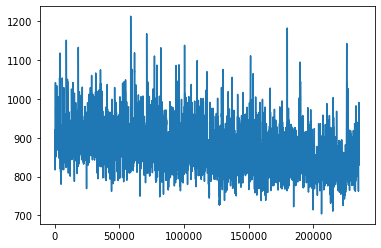

In [8]:
dfrel['grnL'].iloc[:].plot()

<AxesSubplot:>

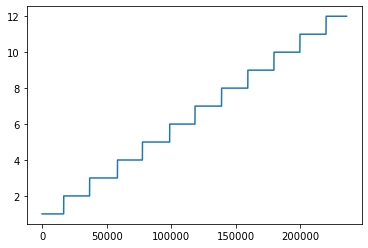

In [9]:
dfrel['iBlock'].iloc[:].plot()

# Timeshift all non-response columns forward and backward ts timesteps

In [10]:

dfrel = sglm_ez.timeshift_cols(dfrel, X_cols[2:], neg_order=-10, pos_order=10)
X_cols_sftd = sglm_ez.add_timeshifts_to_col_list(X_cols, X_cols[2:], neg_order=-10, pos_order=10)
# X_setup = sglm_ez.diff_cols(X_setup, ['A', 'B'])
# X_setup = sglm_ez.setup_autoregression(X_setup, ['B'], 4)

dfrel = dfrel.dropna()


In [11]:
X_setup = dfrel[X_cols]
# X_setup = dfrel[X_cols_sftd]
y_setup = dfrel[y_col]

X_setup.head()

,nTrial,iBlock,ENLPenalty,responseTime,Cue,decision,switch,selReward,post,lickReward,lickNoReward,lickLeft,lickRight,lickSwitch,grnR,grnL
10,4.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,158.45584,917.72960
11,4.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,158.48213,919.08923
12,4.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,158.50370,919.03200
13,4.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,158.51870,919.99945
14,4.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,158.52820,919.73600


<AxesSubplot:>

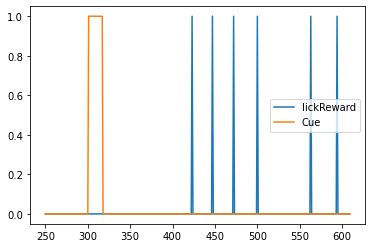

In [12]:
X_setup.iloc[240:600, [9, 4]].plot() # Make this tone one point — make it binned (one and only one point) — use tone duration as binning factor, then make it look like a delta function
# Data has to be collapsed based on when tone starts

In [13]:
# Sum of values in binning windows

In [14]:
X_setup.groupby(['nTrial']).count()

,iBlock,ENLPenalty,responseTime,Cue,decision,switch,selReward,post,lickReward,lickNoReward,lickLeft,lickRight,lickSwitch,grnR,grnL
nTrial,,,,,,,,,,,,,,,
4.0,975,975,975,975,975,975,975,975,975,975,975,975,975,975,975
5.0,1062,1062,1062,1062,1062,1062,1062,1062,1062,1062,1062,1062,1062,1062,1062
6.0,1073,1073,1073,1073,1073,1073,1073,1073,1073,1073,1073,1073,1073,1073,1073
7.0,1054,1054,1054,1054,1054,1054,1054,1054,1054,1054,1054,1054,1054,1054,1054
8.0,1090,1090,1090,1090,1090,1090,1090,1090,1090,1090,1090,1090,1090,1090,1090
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
231.0,1102,1102,1102,1102,1102,1102,1102,1102,1102,1102,1102,1102,1102,1102,1102
232.0,1019,1019,1019,1019,1019,1019,1019,1019,1019,1019,1019,1019,1019,1019,1019
233.0,980,980,980,980,980,980,980,980,980,980,980,980,980,980,980


In [15]:
# # investigate_X = X_setup[[_ for _ in X_setup.columns if _ not in ['nTrial', 'iBlock', 'TO', 'Select', 'Consumption', 'selHigh']]]
# # (investigate_X.corr()-np.eye(investigate_X.shape[1])).abs().max(axis=1)

# from sklearn.decomposition import PCA
# pca = PCA()
# X_setup_pca = pca.fit_transform(X_setup[[_ for _ in X_setup.columns if _ != 'TO']].iloc[:, 2:])



In [16]:
# %matplotlib inline
# plt.plot(pca.explained_variance_[1:])
# pca.explained_variance_.min()

In [17]:
pd.DataFrame(X_setup).corr()

,nTrial,iBlock,ENLPenalty,responseTime,Cue,decision,switch,selReward,post,lickReward,lickNoReward,lickLeft,lickRight,lickSwitch,grnR,grnL
nTrial,1.000000,0.996422,-0.002267,0.056916,0.001156,-0.002863,0.000791,-0.001478,-0.003007,-0.002421,-0.001519,0.004505,-0.010075,0.000170,-0.937968,-0.454164
iBlock,0.996422,1.000000,-0.002270,0.061686,0.001131,-0.002583,0.001050,-0.001658,-0.002994,-0.003076,-0.000916,0.003596,-0.009727,0.000419,-0.934490,-0.456689
ENLPenalty,-0.002267,-0.002270,1.000000,-0.001110,-0.000465,0.000024,0.000083,-0.000053,-0.000079,-0.000319,-0.000084,0.047217,-0.000219,-0.000086,0.002230,-0.001439
responseTime,0.056916,0.061686,-0.001110,1.000000,-0.013552,-0.021718,-0.074922,0.047428,0.070911,-0.027822,-0.007367,0.003355,0.002120,0.013485,-0.043961,-0.074627
Cue,0.001156,0.001131,-0.000465,-0.013552,1.000000,0.000882,0.003042,-0.001925,-0.002879,-0.011662,-0.003088,-0.009856,-0.008017,-0.003157,-0.006599,-0.079041
decision,-0.002863,-0.002583,0.000024,-0.021718,0.000882,1.000000,0.210667,-0.004385,0.395226,0.000604,0.000160,-0.247345,0.196405,-0.011241,0.001475,-0.006039
switch,0.000791,0.001050,0.000083,-0.074922,0.003042,0.210667,1.000000,-0.434799,-0.484745,0.002085,0.000552,-0.198409,-0.136019,0.046194,-0.002297,-0.003744
selReward,-0.001478,-0.001658,-0.000053,0.047428,-0.001925,-0.004385,-0.434799,1.000000,0.331614,-0.001320,-0.000349,0.099872,0.118499,0.056670,0.001497,0.000689
post,-0.003007,-0.002994,-0.000079,0.070911,-0.002879,0.395226,-0.484745,0.331614,1.000000,-0.001973,-0.000522,0.061353,0.278087,0.181455,0.002898,0.002783
lickReward,-0.002421,-0.003076,-0.000319,-0.027822,-0.011662,0.000604,0.002085,-0.001320,-0.001973,1.000000,-0.002116,0.712075,0.571837,0.179764,0.006983,0.064652


In [18]:
(pd.DataFrame(X_setup).corr() - np.eye(X_setup.shape[1])).abs().max(axis=1)

nTrial          0.996422
iBlock          0.996422
ENLPenalty      0.047217
responseTime    0.074922
Cue             0.079041
decision        0.395226
switch          0.484745
selReward       0.434799
post            0.484745
lickReward      0.712075
lickNoReward    0.177203
lickLeft        0.712075
lickRight       0.571837
lickSwitch      0.193297
grnR            0.937968
grnL            0.487655
dtype: float64

In [19]:
# pd.DataFrame(X_setup_pca).corr()

In [20]:
X_setup.describe()

,nTrial,iBlock,ENLPenalty,responseTime,Cue,decision,switch,selReward,post,lickReward,lickNoReward,lickLeft,lickRight,lickSwitch,grnR,grnL
count,235712.000000,235712.000000,235712.000000,235712.000000,235712.000000,235712.000000,235712.000000,235712.000000,235712.000000,235712.000000,235712.000000,235712.000000,235712.000000,235712.000000,235712.000000,235712.000000
mean,118.906110,6.470880,0.000013,0.088298,0.016732,-0.000208,-0.000717,0.000454,0.000413,0.007929,0.000560,0.005676,0.003763,0.000585,155.323962,866.210502
std,67.001478,3.359779,0.003568,0.283729,0.128267,0.030758,0.030750,0.030755,0.018692,0.088692,0.023658,0.075128,0.061228,0.024189,1.053817,52.263226
min,4.000000,1.000000,0.000000,0.000000,0.000000,-1.000000,-1.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,153.049130,703.700800
25%,60.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,154.457058,830.452300
50%,119.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,155.125440,861.684420
75%,177.000000,9.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,156.064590,895.211000
max,235.000000,12.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.988804,1.000000,1.000000,1.000000,1.000000,1.000000,158.794200,1212.781100


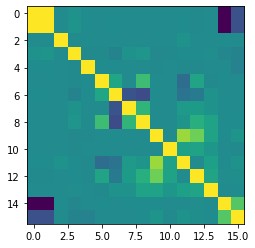

In [21]:
plt.imshow(X_setup.corr())

In [22]:
X_setup

,nTrial,iBlock,ENLPenalty,responseTime,Cue,decision,switch,selReward,post,lickReward,lickNoReward,lickLeft,lickRight,lickSwitch,grnR,grnL
10,4.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,158.45584,917.72960
11,4.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,158.48213,919.08923
12,4.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,158.50370,919.03200
13,4.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,158.51870,919.99945
14,4.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,158.52820,919.73600
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235717,235.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,154.34094,841.02045
235718,235.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,154.32259,840.68680
235719,235.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,154.28929,839.44165
235720,235.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,154.24985,839.26710


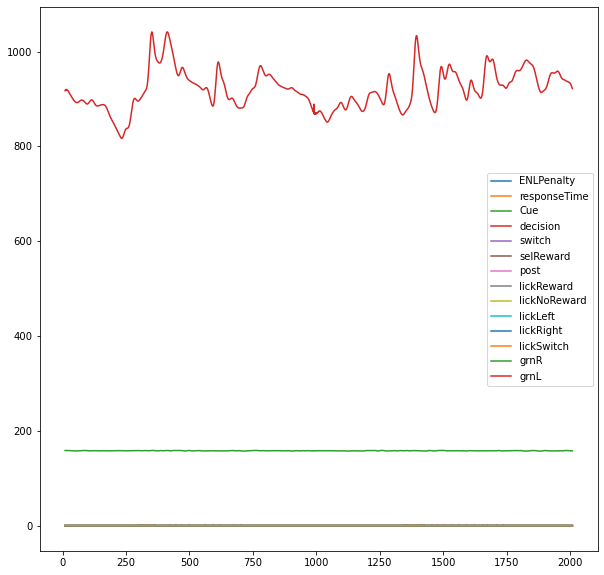

In [23]:
plt.figure(figsize=(10,10))
plt.plot(X_setup.iloc[:2000, 2:])
plt.legend(X_setup.columns[2:])

In [24]:
for col in X_setup.columns:
    print(f'{col}:', X_setup.query(f'{col} > 0').groupby(['nTrial', col])['post'].count().min())

nTrial: 856
iBlock: 856
ENLPenalty: 1
responseTime: 6
Cue: 17
decision: 1
switch: 1
selReward: 1
post: 1
lickReward: 5
lickNoReward: 1
lickLeft: 1
lickRight: 1
lickSwitch: 1
grnR: 1
grnL: 1


In [26]:
# sglm_ez.timeshift_cols(X_setup, [_ for _ in X_setup.columns[2:] if _ not in ['Cue', 'Reward', 'post']], neg_order=0, pos_order=100)
# sglm_ez.timeshift_cols_by_signal_length(X_setup, ['Cue', 'Reward', 'post'], neg_order=0, pos_order=1000, shift_amt_ratio=2).iloc[:50]

In [290]:
import pandas as pd
# df = pd.read_csv(f'../dlight_only_WT35_12212020.csv')
df = pd.read_csv(f'../dlight_only_WT36_12212020.csv')
df = df[[_ for _ in df.columns if 'Unnamed' not in _]]

# .drop('Unnamed: 16', axis=1).drop('Unnamed: 17', axis=1) # .drop('index', axis=1)

print(df.columns)

df = df.rename({'center port occupancy': 'cpo',
                'center port entry': 'cpn',
                'center port exit': 'cpx',

                'left port occupancy': 'lpo',
                'left port entry': 'lpn',
                'left port exit': 'lpx',
                'left licks': 'll',

                'right port occupancy': 'rpo',
                'right port entry': 'rpn',
                'right port exit': 'rpx',
                'right licks': 'rl',

                'no reward': 'nr',
                'reward': 'r',

                'dF/F green (dLight1.1)': 'gdFF',
                'zscored green (dLight1.1)': 'zsgdFF'}, axis=1)

df['event_col_a'] = ((df['cpo'].diff() > 0)*1).replace(0, np.nan) * 1.0
df['event_col_b'] = df['nr'].replace(0, np.nan) * 2.0
df['event_col_c'] = df['r'].replace(0, np.nan) * 3.0

df['event_col'] = df['event_col_a'].combine_first(df['event_col_b']).combine_first(df['event_col_c'])

df = df.drop(['event_col_a', 'event_col_b', 'event_col_c'], axis=1)

df['event_col'] = df['event_col'].bfill()
df['trial_start_flag'] = (df['event_col'] == 1.0)&(df['event_col'].shift(-1) != df['event_col']) * 1.0

df['nTrial'] = df['trial_start_flag'].cumsum().shift(-10).ffill()


Index(['time (msec)', 'center port entry', 'center port occupancy',
       'center port exit', 'left port entry', 'left port occupancy',
       'left port exit', 'left licks', 'right port entry',
       'right port occupancy', 'right port exit', 'right licks', 'no reward',
       'reward', 'dF/F green (dLight1.1)', 'zscored green (dLight1.1)'],
      dtype='object')


In [291]:
df['r'].iloc[4300:4500].sum()

1.0

<AxesSubplot:>

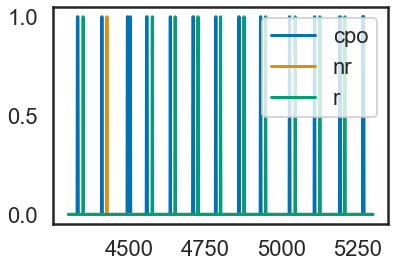

In [292]:
df[['cpo','nr','r']].iloc[4300:5300].plot()

In [293]:
# function [idx, val] = closest_v2(testArr,val)
# tmp=find(testArr<=val);
# idx=tmp(end);
# val=testArr(idx);

df['cpo']

0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
36994    NaN
36995    NaN
36996    NaN
36997    NaN
36998    NaN
Name: cpo, Length: 36999, dtype: float64

In [310]:
import numpy as np

df['event_col_a'] = ((df['cpo'].diff() > 0)*1).replace(0, np.nan) * 1.0
df['event_col_b'] = (df['nr']).replace(0, np.nan) * 2.0
df['event_col_c'] = (df['r']).replace(0, np.nan) * 3.0
df['event_col_d'] = ((df['lpx'] > 0)*1.0).replace(0, np.nan) * 1.0
df['event_col_e'] = ((df['rpx'] > 0)*1.0).replace(0, np.nan) * 1.0

df['event_col_start'] = df['event_col_a'].combine_first(df['event_col_b']).combine_first(df['event_col_c'])
df['event_col_end'] = df['event_col_d'].combine_first(df['event_col_e']).combine_first(df['event_col_b']).combine_first(df['event_col_c'])

# df = df.drop(['event_col_a', 'event_col_b', 'event_col_c'], axis=1)

df['event_col_start'] = df['event_col_start'].bfill()
df['trial_start_flag'] = ((df['event_col_start'] == 1.0)&(df['event_col_start'].shift(-1) != df['event_col_start']) * 1.0).shift(-5) * 1.0
df['nTrial'] = df['trial_start_flag'].cumsum()

df['event_col_end'] = df['event_col_end'].ffill()
# df['trial_end_flag'] = ((df['event_col_start'] != 1.0)&(df['event_col_start'].shift(-1) == 1.0)&(df['event_col_start'].shift(-1) != df['event_col_start']) * 1.0).shift(5) * 1.0
df['trial_end_flag'] = ((df['event_col_end'] == 1.0)&(df['event_col_end'].shift(1) != 1.0)&(df['event_col_end'].shift(1) != df['event_col_end'])&(df['nTrial'] > 0) * 1.0).shift(5) * 1.0
df['nEndTrial'] = df['trial_end_flag'].cumsum()


(<AxesSubplot:>, <AxesSubplot:>)

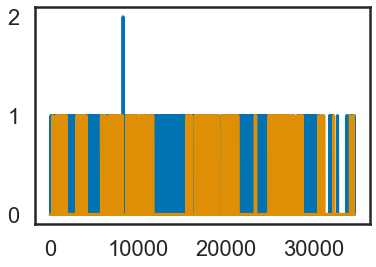

In [311]:
df['lpx'].plot(), df['rpx'].plot()

<AxesSubplot:>

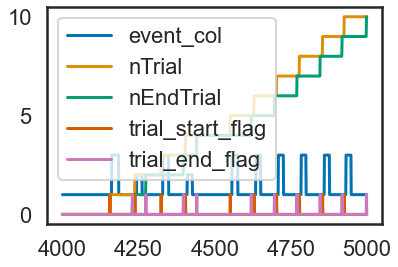

In [312]:
df[['event_col', 'nTrial', 'nEndTrial', 'trial_start_flag', 'trial_end_flag']].iloc[4000:5000].plot()

In [313]:
df['trial_start_flag'] = (df['event_col'] == 1.0)&(df['event_col'].shift(-1) != df['event_col']) * 1.0
df

,time (msec),cpn,cpo,cpx,lpn,lpo,lpx,ll,rpn,rpo,...,nTrial,event_col_a,event_col_b,event_col_c,event_col_d,event_col_e,event_col_start,event_col_end,trial_end_flag,nEndTrial
0,50,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
1,100,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
2,150,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
3,200,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
4,250,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36994,1849750,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0,251
36995,1849800,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0,251
36996,1849850,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0,251
36997,1849900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0,251


<AxesSubplot:>

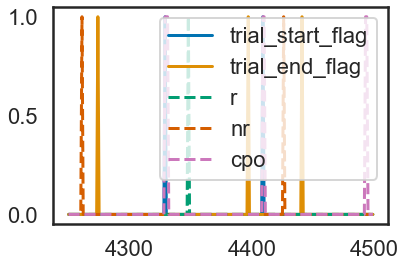

In [314]:
(df.iloc[4250:4500][['trial_start_flag', 'trial_end_flag', 'r', 'nr', 'cpo']] * 1.0).plot(style=['-', '-', '--', '--', '--'])

# Define trial splits based on 500 ms (10 timesteps) prior to the center port occupancy that begins a trial.

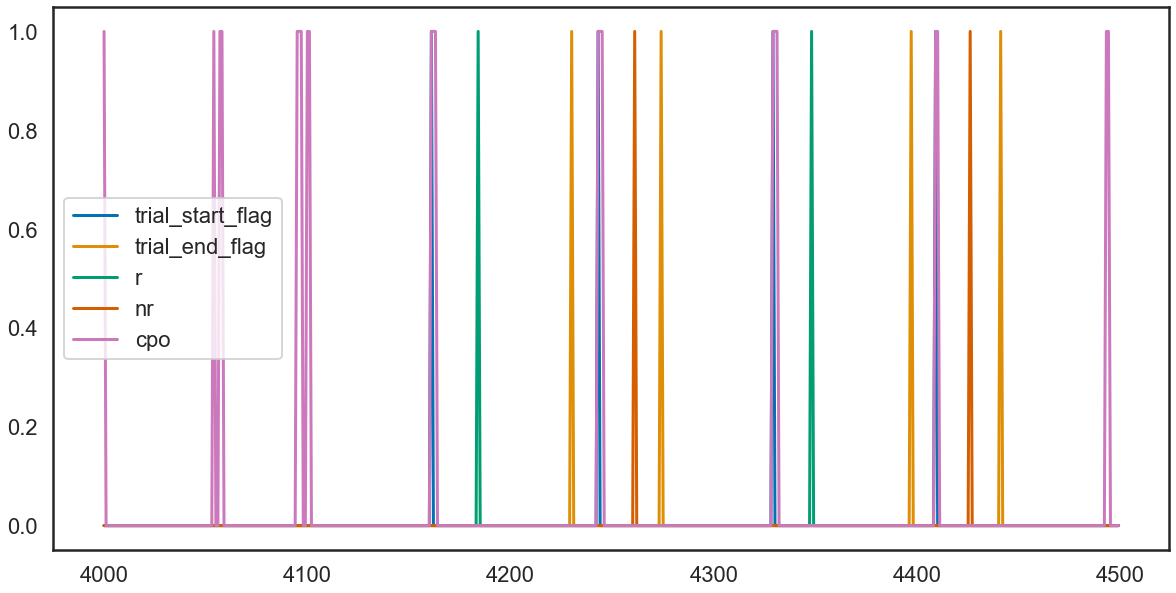

In [315]:
plt.figure(figsize=(20,10))
plt.plot(df.iloc[4000:4500][['trial_start_flag', 'trial_end_flag', 'r', 'nr', 'cpo']] * 1.0)
plt.legend(['trial_start_flag', 'trial_end_flag', 'r', 'nr', 'cpo'])


In [316]:
# df['nTrial'] = df['trial_start_flag'].cumsum().shift(-10).ffill() / 10
# (df[['nTrial', 'cpo', 'nr', 'r']].eval('nTrial = (nTrial % 2)*2')).iloc[-10100:-7500].plot()

<AxesSubplot:>

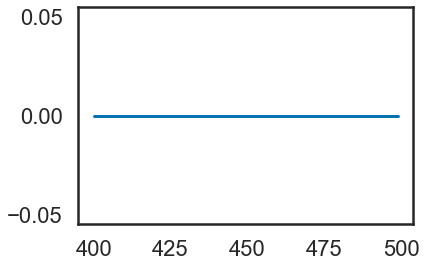

In [317]:
df['rl'].iloc[400:500].plot()

<AxesSubplot:>

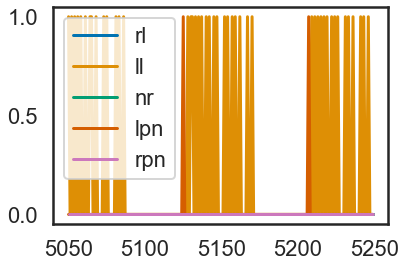

In [318]:
df[['rl','ll','nr','lpn','rpn']].iloc[5050:5250].plot()

<AxesSubplot:>

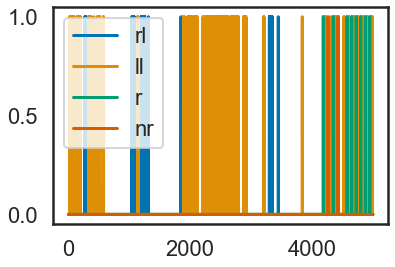

In [319]:
df[['rl','ll','r','nr']].iloc[:5000].plot()


In [320]:
# y_setup_col = 'rdFF' # photometry response
# df = sglm_ez.diff_cols(df, ['rdFF'])

X_cols = [
    'nTrial',
    'nEndTrial',
    #'cpo',
    'cpn', 'cpx',
    #'lpo',
    'lpn', 'lpx',
    'll',
    #'rpo',
    'rpn', 'rpx',
    'rl',
    'nr', 'r'
]

# y_col = 'gdFF'
y_col = 'zsgdFF'
# y_col = 'grnR'

dfrel = df[X_cols + [y_col]].copy()
dfrel = dfrel.replace('False', 0).astype(float)
dfrel = dfrel*1

print(dfrel)
print(X_cols)

neg_order = -30
pos_order = 30


dfrel = sglm_ez.timeshift_cols(dfrel, X_cols[2:], neg_order=neg_order, pos_order=pos_order)
X_cols_sftd = sglm_ez.add_timeshifts_to_col_list(X_cols, X_cols[2:], neg_order=neg_order, pos_order=pos_order)

print(dfrel.shape)
print(X_cols_sftd)

dfrel = dfrel.dropna()

X_setup = dfrel[X_cols_sftd].copy()
y_setup = dfrel[y_col].copy()

X_setup.head()


       nTrial  nEndTrial  cpn  cpx  lpn  lpx   ll  rpn  rpx   rl   nr    r  \
0         0.0        NaN  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1         0.0        NaN  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2         0.0        NaN  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3         0.0        NaN  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
4         0.0        NaN  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
...       ...        ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
36994     NaN      251.0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
36995     NaN      251.0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
36996     NaN      251.0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
36997     NaN      251.0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
36998     NaN      251.0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   

       zsgdFF  
0         0.0  
1         0.0  
2         0.0  

,nTrial,nEndTrial,cpn,cpx,lpn,lpx,ll,rpn,rpx,rl,...,cpn_30,cpx_30,lpn_30,lpx_30,ll_30,rpn_30,rpx_30,rl_30,nr_30,r_30
30,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
32,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
33,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
34,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [336]:
holdout = sglm_ez.holdout_split_by_trial_id(X_setup, y_setup, id_cols=['nTrial'], perc_holdout=0.2)

X_tr = X_setup[~holdout]
y_tr = y_setup[~holdout]

X_te = X_setup[holdout]
y_te = y_setup[holdout]


best_params = {'max_iter': 1000, 'alpha': 0.001, 'l1_ratio': 0.5, 'fit_intercept': True}
glm = sglm_ez.fit_GLM(X_tr, y_tr, **best_params)

/Users/josh/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9935.91964027429, tolerance: 2.5082133827708795
  model = cd_fast.enet_coordinate_descent(


In [337]:
tr_keep = (X_tr['nTrial'] != X_tr['nEndTrial'])
te_keep = (X_te['nTrial'] != X_te['nEndTrial'])
(glm.model.score(X_tr, y_tr),
    glm.model.score(X_te, y_te),
    glm.model.score(X_tr[tr_keep], y_tr[tr_keep]),
    glm.model.score(X_te[te_keep], y_te[te_keep]))

(0.19518148680497904,
 0.13318762738936085,
 0.2392780506107155,
 0.256795575399525)

<AxesSubplot:>

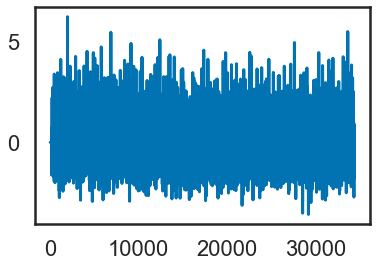

In [338]:
df[y_col].iloc[:].plot()

In [339]:
# # sglm_ez.reconstruct_signal(glm, X_tr.iloc[5000:10000], y_tr.iloc[5000:10000])
# sglm_ez.reconstruct_signal(glm, X_tr, y_tr)
# # plt.plot(X_tr['nTrial'].diff())
# sglm_ez.reconstruct_signal(glm, X_te, y_te)



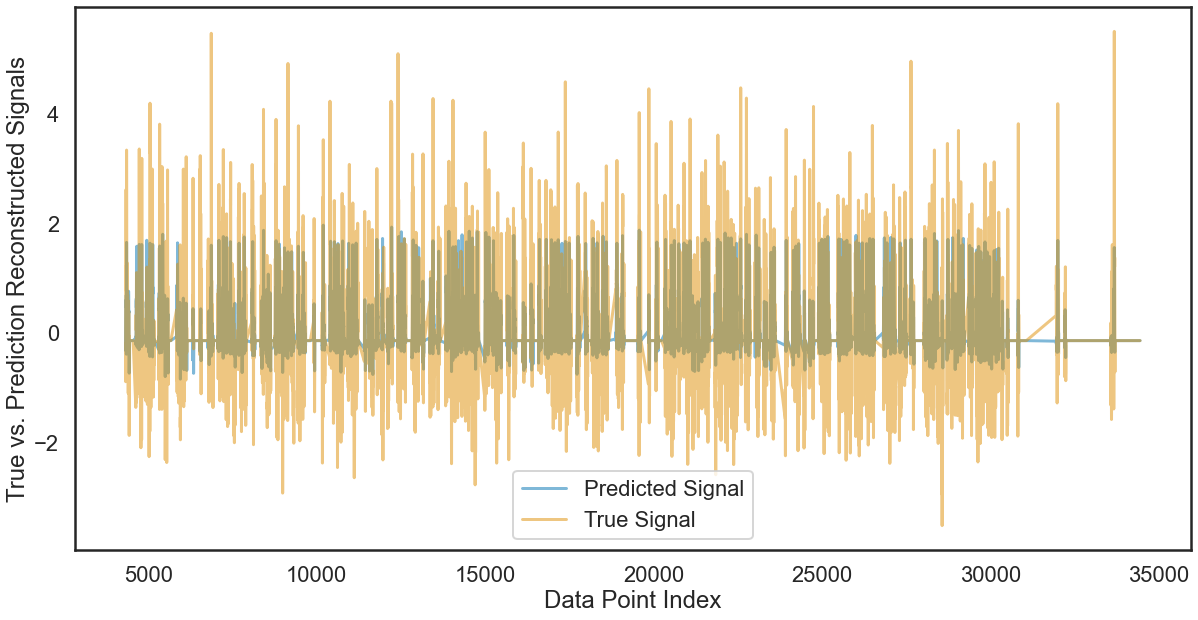

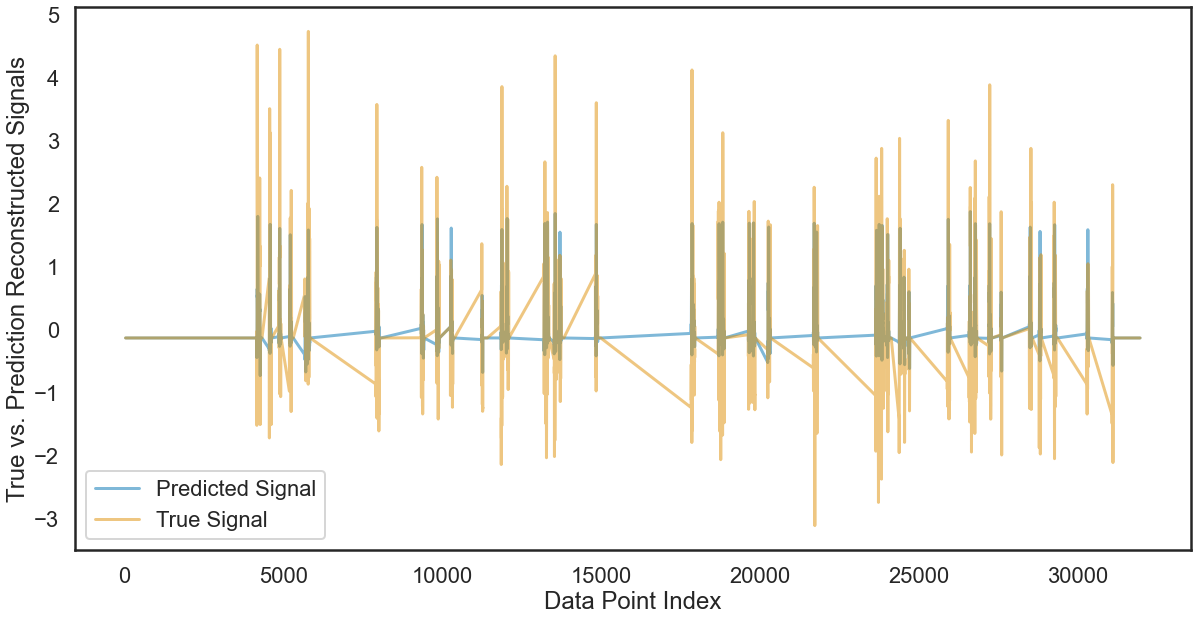

In [340]:
X_tr_nand = X_tr.copy()
X_tr_nand[~tr_keep] = 0
X_te_nand = X_te.copy()
X_te_nand[~te_keep] = 0
y_tr_nand = y_tr.copy()
y_tr_nand[~tr_keep] = glm.intercept_
y_te_nand = y_te.copy()
y_te_nand[~te_keep] = glm.intercept_


# sglm_ez.reconstruct_signal(glm, X_tr.iloc[5000:10000], y_tr.iloc[5000:10000])
sglm_ez.reconstruct_signal(glm, X_tr_nand, y_tr_nand)
# plt.plot(X_tr['nTrial'].diff())
sglm_ez.reconstruct_signal(glm, X_te_nand, y_te_nand)
